# Exercise 08

## Analyze how travelers expressed their feelings on Twitter

A sentiment analysis job about the problems of each major U.S. airline. 
Twitter data was scraped from February of 2015 and contributors were 
asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# read the data and set the datetime as the index
import zipfile
with zipfile.ZipFile('../datasets/Tweets.zip', 'r') as z:
    f = z.open('Tweets.csv')
    tweets = pd.read_csv(f, index_col=0)

tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
tweets.shape

(14640, 14)

### Proportion of tweets with each sentiment

In [3]:
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Proportion of tweets per airline


In [4]:
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

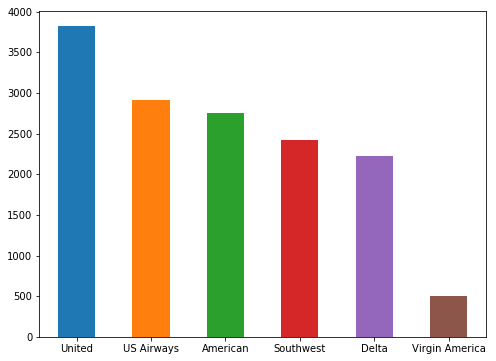

In [5]:
pd.Series(tweets["airline"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)

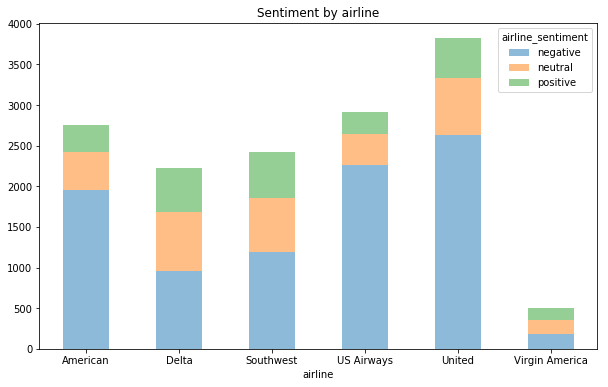

In [6]:
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment by airline")

# Exercise 8.1 

Predict the sentiment using CountVectorizer, stopwords, n_grams, stemmer, TfidfVectorizer

use Random Forest classifier

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [54]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### CountVectorizer, stopwords, n_grams

In [10]:
# use CountVectorizer to create document-term matrices from X
vect = CountVectorizer(ngram_range=(1, 3), stop_words='english', max_features=10000)
X_dtm = vect.fit_transform(X_train)
# rows are documents, columns are terms (aka "tokens" or "features")
X_dtm.shape

(7320, 10000)

In [11]:
# use RandomForestClassifier() to predict the star rating
clf = RandomForestClassifier()
pd.Series(cross_val_score(clf, X_dtm, y_train, cv=10)).describe()

count    10.000000
mean      0.711206
std       0.017655
min       0.686221
25%       0.703589
50%       0.705119
75%       0.716537
max       0.747268
dtype: float64

### CountVectorizer, stopwords, n_grams, stemmer

In [12]:
# initialize stemmer
stemmer = SnowballStemmer('english')

# define a function that accepts text and returns a list of lemmas
def split_into_stemmer(text):
    text = text.lower()
    words = text.split()
    return [stemmer.stem(word) for word in words]

In [13]:
# use split_into_lemmas as the feature extraction function (WARNING: SLOW!)
vect = CountVectorizer(analyzer=split_into_stemmer,ngram_range=(1, 3), stop_words='english', max_features=10000)
X_dtm = vect.fit_transform(X_train)
# rows are documents, columns are terms (aka "tokens" or "features")
X_dtm.shape

(7320, 10000)

In [14]:
# use RandomForestClassifier() to predict the star rating
clf = RandomForestClassifier()
pd.Series(cross_val_score(clf, X_dtm, y_train, cv=10)).describe()

count    10.000000
mean      0.706140
std       0.013802
min       0.682627
25%       0.697954
50%       0.705195
75%       0.711066
max       0.728513
dtype: float64

### TfidfVectorizer

In [15]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english', max_features=10000)
dtm = vect.fit_transform(X_train)
dtm.shape

(7320, 9940)

In [16]:
# use RandomForestClassifier() to predict the star rating
clf = RandomForestClassifier()
pd.Series(cross_val_score(clf, dtm, y_train, cv=10)).describe()

count    10.000000
mean      0.712165
std       0.014026
min       0.688950
25%       0.706666
50%       0.714290
75%       0.722525
max       0.730874
dtype: float64

### TfidfVectorizer, stemmer, ngram, stop_words

In [17]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(analyzer=split_into_stemmer,ngram_range=(1, 3), stop_words='english', max_features=10000)
dtm = vect.fit_transform(X_train)
dtm.shape

(7320, 10000)

In [18]:
# use RandomForestClassifier() to predict the star rating
clf = RandomForestClassifier()
pd.Series(cross_val_score(clf, dtm, y_train, cv=10)).describe()

count    10.000000
mean      0.707787
std       0.005716
min       0.697674
25%       0.703615
50%       0.707850
75%       0.712281
max       0.715847
dtype: float64

### Performance over test
Se seleccionó cTfidfVectorizer dado que tiene un promedio alto y la menos deviación estandar entre todos los calibrados

In [19]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english', max_features=9000)
dtm = vect.fit_transform(X_train)
dtm.shape

(7320, 9000)

In [20]:
# use RandomForestClassifier() to predict the star rating
clf = RandomForestClassifier()
clf.fit(dtm, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
dtm_test = vect.fit_transform(X_test)
dtm.shape

(7320, 9000)

In [22]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(dtm_test)
accuracy_score(y_test, y_pred)

0.6204918032786885

# Exercise 8.2

Train a Deep Neural Network with the following architecture:

- Input = text 
- Dense(128)
- Relu Activation
- BatchNormalization
- Dropout(0.5)
- Dense(10, Softmax)

Optimized using rmsprop using as loss categorical_crossentropy

Hints: 
- test with two iterations then try more. 
- learning can be ajusted

Evaluate the performance using the testing set (aprox 55% with 50 epochs)

In [151]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import History
from livelossplot import PlotLossesKeras
import tensorflow as tf

In [152]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english', max_features=9000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.fit_transform(X_test)
X_train_dtm.shape, X_test_dtm.shape

((7320, 9000), (7320, 9000))

In [153]:
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)
y_train_cat.shape, y_test_cat.shape

((7320, 3), (7320, 3))

In [154]:
np.random.seed(123)
tf.set_random_seed(123)

model = Sequential()

model.add(Dense(128,input_shape=(9000,) ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 128)               1152128   
_________________________________________________________________
activation_19 (Activation)   (None, 128)               0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1290      
_________________________________________________________________
dropout_27 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 33        
Total para

In [155]:
np.random.seed(123)
tf.set_random_seed(123)

rmsprop = RMSprop(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer= rmsprop, metrics=['accuracy'])

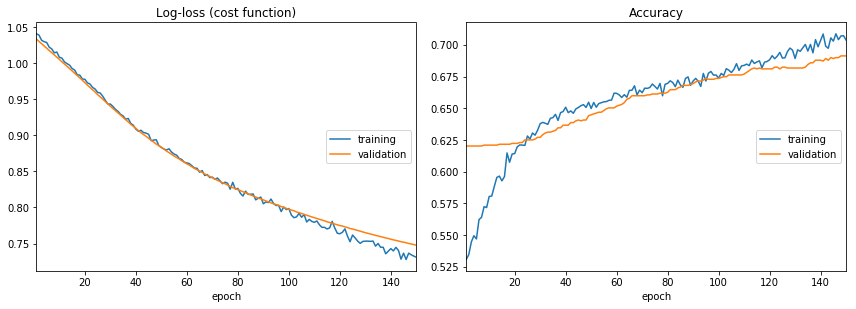

In [156]:
np.random.seed(123)
tf.set_random_seed(123)

batch_size = 32
epochs = 150
history = model.fit(X_train_dtm, y_train_cat, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2,callbacks=[PlotLossesKeras()])

In [157]:
y_pred = model.predict_classes(X_test_dtm)
(y_pred==y_test_cat.argmax(axis=1)).mean()

0.6299180327868853

In [158]:
score = model.evaluate(X_test_dtm, y_test_cat)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7320/7320 [==============================] - 1s 135us/step
Test score: 0.9355145709110739
Test accuracy: 0.6299180327217435
